In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dv = np.load("data/cl_gg_input.npy")
zz, nz = np.load("data/dndz_input_z3_galaxy_field_lsstlike.npy")

In [53]:
len(zz)

100

In [51]:
# Fit a Gaussian to your dN/dz data
from scipy.optimize import curve_fit

def gaussian(x, mean, std, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mean) / std)**2)

# Fit the Gaussian to your data
popt, _ = curve_fit(gaussian, zz, dv, p0=[1.0, 0.1, np.max(dv)])
mean_fit, std_fit, amp_fit = popt

# Plot original distribution and fitted Gaussian
plt.figure(figsize=(10, 6))
plt.plot(zz, dv, 'b-', label='Original dN/dz')
plt.plot(zz, gaussian(zz, mean_fit, std_fit, amp_fit), 'r--', label='Fitted Gaussian')
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.legend()
plt.title(f'Fitted Gaussian: mean={mean_fit:.3f}, σ={std_fit:.3f}')

# Update the base_params with the fitted values
base_params.update({
    'selection': 'gaussian',
    'selection_mean': f'{mean_fit}',
    'selection_width': f'{std_fit}'
})

ValueError: operands could not be broadcast together with shapes (100,) (2200,) 

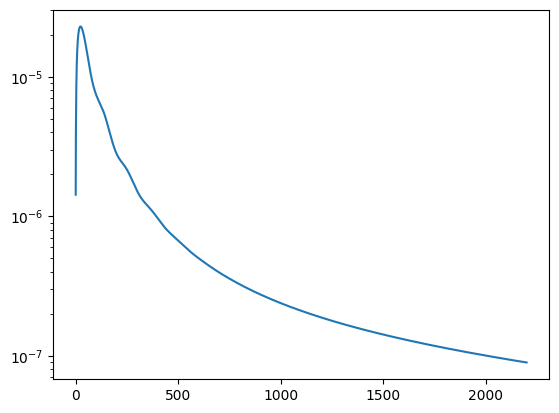

In [5]:
plt.semilogy(dv)

In [ ]:
from classy import Class
lmax = 2200
base_params = {
    # Saídas necessárias (CMB + LSS)
    'modes': 's',
    'output': 'tCl, pCl, lCl, mPk, nCl, dCl',
    'lensing': 'yes',
    'l_max_scalars': lmax,
    'l_max_lss': lmax,
    'number_count_contributions': 'density',

    # Energia escura via fld
    'Omega_Lambda': 0,
    'w0_fld': '-1.',
    'wa_fld': '0.0',

    # Espectro primordial (n_s fixo; sigma8 varia no loop)
    'n_s': 0.96,

    # Verbosidade e gauge
    'background_verbose': 0,
    'perturbations_verbose': 0,
    'gauge': 'Synchronous',

    # P(k) linear
    'z_pk': '1.0, 0.0',
    'P_k_max_h/Mpc': 10,
    'k_per_decade_for_pk': 30,

    # Fundo
    'h': 0.673,
    'Omega_b': 0.03,
    'A_s': 2.1e-9,

    # Seleção LSS (usando gaussian bin)
    'selection': 'gaussian',
    'selection_mean': '0.9',  # will be updated with fitted value
    'selection_width': '0.1', # will be updated with fitted value
    'selection_bias': '1'
}

def get_cl_gg(Omega_m, sigma_8):
    """
    Tenta rodar o CLASS com 'selection_bias' e, se falhar por chave desconhecida,
    tenta novamente com 'bias'. Retorna (ell, Cl_gg) para o bin 1.
    """

    cosmo = Class()
    params = base_params.copy()
    params.update({
        'Omega_cdm': Omega_m - 0.05, # TODO: include massive neutrinos
    })
    
    cosmo.set(params)
    cosmo.compute()
    
    # Ajustar A_s para obter o sigma_8 desejado
    current_sigma8 = cosmo.sigma8()
    scaling = (sigma_8/current_sigma8)**2
    cosmo.struct_cleanup()  # Limpar para recalcular
    
    # Recomputar com o A_s ajustado
    params['A_s'] *= scaling
    cosmo.set(params)
    cosmo.compute()
    
    # Se chegamos aqui, deu certo: extrair Cl^{gg}
    cl_dens = cosmo.density_cl(lmax)

    # Formato aninhado (ex.: cl_dens['dd']['dens[1]-dens[1]'])
    if 'dd' in cl_dens and isinstance(cl_dens['dd'], dict):
        if 'dens[1]-dens[1]' in cl_dens['dd']:
            Cl_gg = cl_dens['dd']['dens[1]-dens[1]']
        else:
            # fallback: pega primeira série de densidade disponível
            Cl_gg = list(cl_dens['dd'].values())[0]
        ell = np.arange(len(Cl_gg))
    else:
        # Formato "plano": procure por chaves 'dd_1_1', 'density_1_1', etc.
        gg_keys = [k for k in cl_dens.keys()
                    if ('_1_1' in k) and any(tag in k for tag in ['dd', 'density', 'number_count'])]
        if not gg_keys:
            gg_keys = [k for k in cl_dens.keys()
                        if 'density' in k or 'number_count' in k or k.startswith('dd')]
        if not gg_keys:
            raise RuntimeError("Não encontrei Cl^{gg} em density_cl(); inspecione as chaves com print(cl_dens.keys()).")
        Cl_gg = cl_dens[gg_keys[0]]
        ell = cl_dens.get('ell', np.arange(len(Cl_gg)))

    # Verificar o sigma_8 final
    final_sigma8 = cosmo.sigma8()
    print(f"Target σ₈: {sigma_8:.3f}, Achieved σ₈: {final_sigma8:.3f}")

    return ell, np.asarray(Cl_gg), cosmo  # retorna o cosmo se quiser reaproveitar

In [49]:
ell, cl_gg, _ = get_cl_gg(0.18, 0.840)
plt.semilogy(ell[2:], cl_gg[2:], label="Teoria")
plt.semilogy(ell[2:2200], dv[2:], label="Dados")
plt.legend()

CosmoSevereError: 

Error in Class: input_read_from_file(L:428) :error in input_read_parameters(pfc,ppr,pba,pth,ppt,ptr,ppm,phr,pfo,ple,psd,pop, errmsg);
=>input_read_parameters(L:1705) :error in input_read_parameters_spectra(pfc,ppr,pba,ppm,ppt,ptr,phr,pop, errmsg);
=>input_read_parameters_spectra(L:4768) :error; You specified 'selection' as 'dNdz'. It has to be one of {'gaussian','tophat','dirac'}.

Text(0, 0.5, 'Probability Density')

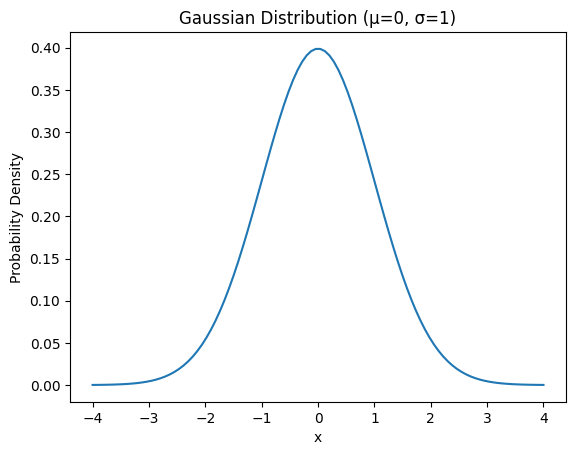